In [1]:
import pandas as pd
import numpy as np
import io
from google.colab import files
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#ONLY upload test notes as a test

# define an empty list
test_notes_cleaned = []
train_notes_cleaned = []

train_notes = pd.read_csv('gdrive/MyDrive/BMI707_Final_Project/TRAINING_notes_cleaned.csv')
train_notes = list(train_notes['0'])

test_notes = pd.read_csv('gdrive/MyDrive/BMI707_Final_Project/VALDIATION_notes_cleaned.csv')
test_notes = list(test_notes['0'])

ftest_notes = pd.read_csv('gdrive/MyDrive/BMI707_Final_Project/test_notes_cleaned.csv', header=None)
ftest_notes = list(ftest_notes.iloc[:, 0])

ftest_notes[0]

"['pleural', 'asp', 'radiologist', 'right', 'guidance', 'female', 'first', 'name', 'un', 'centesis', 'usclip', 'telephonefax', 'chest', 'u', 'reason', 'fever', 'r', 'side', 'pleural', 'effusion', 'procedure', 'approve', 'hospital', 'medical', 'condition', 'year', 'old', 'woman', 'sp', 'sahsdh', 'pleural', 'effusion', 'reason', 'examination', 'fever', 'r', 'side', 'pleural', 'effusion', 'procedure', 'approve', 'dr', 'first', 'last', 'name', 'please', 'aware', 'ventricular', 'pleural', 'shunt', 'r', 'side', 'final', 'report', 'indication', 'year', 'old', 'status', 'post', 'subarachnoid', 'subdural', 'hemorrhage', 'fever', 'rightsided', 'pleural', 'effusion', 'ultrasound', 'guide', 'thoracentesis', 'request', 'ultrasound', 'guided', 'thoracentesis', 'obtain', 'inform', 'verbal', 'consent', 'patient', 'husband', 'via', 'telephone', 'witness', 'right', 'lateral', 'chest', 'wall', 'prepped', 'draped', 'usual', 'sterile', 'fashion', 'utilize', 'ultrasound', 'guidance', 'appropriate', 'spot', 

In [3]:
#concatenate sentences back together
rebuilt_train_notes_cleaned = [note[2:len(train_notes[0])-2].replace("', '", " ") for note in train_notes]
rebuilt_test_notes_cleaned = [note[2:len(test_notes[1])-2].replace("', '", " ") for note in test_notes]
rebuilt_train_notes_cleaned[0]

rebuilt_ftest_notes_cleaned = [note[2:len(ftest_notes[1])-2].replace("', '", " ") for note in ftest_notes]

##Get outcome labels

In [4]:



#extract labels from test and train new sets
outcome_train = pd.read_csv("gdrive/MyDrive/BMI707_Final_Project/TRAINING_full_dataset.csv")
outcome_test = pd.read_csv("gdrive/MyDrive/BMI707_Final_Project/VALIDATION_full_dataset.csv")
outcome_ftest = pd.read_csv("gdrive/MyDrive/BMI707_Final_Project/test_data_balanced.csv")

train_labels_b = np.array(outcome_train.binary_outcome)
test_labels_b = np.array(outcome_test.binary_outcome)

ftest_labels_b = np.array(outcome_ftest.binary_outcome)

#read in continuous outcomes

train_labels_c = np.array(outcome_train.outcome_count)
test_labels_c = np.array(outcome_test.outcome_count)

ftest_labels_c = np.array(outcome_ftest.outcome_count)




##Implement matrix factorization method for obtaining word embeddings

In [ ]:
rebuilt_train_notes_cleaned[0]

'pm chest portable ap clip clip number radiology reason acute sob hospital medical condition year old man pvdischemic llecad heparinwithacute sob low bps reason examination acute sob final report indication shortness breath low blood pressure comparison make previous study earlier day leave picc line remain place terminate distal superior vena cava patient sp mediansternotomy coronary bypass surgery heart enlarge stable size previously note mild congestive heart failure pattern demonstrate significantly change allow difference technique confluent area consolidation see either lung pleural effusion evident although left cp sulcus exclude impression significant change since recent study earlier day persistent mild congestive heart failure pattern'

In [7]:
#create term-document matrix with TFIDF applied
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(rebuilt_train_notes_cleaned)

td_matrix = vectorizer.transform(rebuilt_train_notes_cleaned).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

#implement latent semantic analysis
import sklearn.decomposition
def learn_reps_lsa(matrix, rep_size):
    svd = sklearn.decomposition.TruncatedSVD(n_components = rep_size)
    U = svd.fit_transform(matrix)
    return U


#impmlement TFIDF transformation
def transform_tfidf(matrix):
    matrix = matrix.astype(float)
    
    for i in range(matrix.shape[0]):
      idf = np.log(matrix.shape[1] / np.count_nonzero(matrix[i].toarray()))
      matrix[i] = matrix[i] * idf
    
    return matrix

KeyboardInterrupt: ignored

In [ ]:
#run TFIDF transform and LSA on TD matrix

td_matrix_tfidf = transform_tfidf(td_matrix)
reps_tfidf = learn_reps_lsa(td_matrix_tfidf, 500) #can adjust the 500 dimensions parameter later on

# need to get code to do this
# lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

In [5]:
# torch.save(reps_tfidf, 'gdrive/MyDrive/BMI707_Final_Project/LSA_embed_weights_500dim.pt') 
import torch
#load later on
saved_weights = torch.load('gdrive/MyDrive/BMI707_Final_Project/LSA_embed_weights_500dim.pt', map_location=torch.device('cpu'))

In [8]:
import sklearn.linear_model

reps_tfidf = saved_weights

def lsa_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the learned feature representation of each review (e.g. the sum of LSA 
    # word representations).

    feats = np.zeros((xs.shape[0], reps_tfidf.shape[1]))  
    print('feats shape')
    print(feats.shape)
    print('xs shape')
    print(xs.shape)

    for j in range(xs.shape[0]): #iterate through each clinical note
      
      #shape of reps_tfidf is 10000 (vocab size) x 500(embed dims)
      #shape of xs is 131691 (# of samples) x 10000 (vocab size)

      #multiply the word 0 embedding by the  value in word 0 xs
      # newrow = xs[j,0] * reps_tfidf[0] #multiply a word 0 in note j of by a TFIF word 0 (1x500) 

      # for i in range(1, xs.shape[1]):        #iterate through each term in vocab
      #   newrow += xs[j,i] * reps_tfidf[i]   # represent the sentence as a sum of representations
      
      newrow = sum(xs[j,:] * reps_tfidf[:])

      feats[j] = newrow  

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

print(f"LSA features, {len(outcome_train)} examples")

train_xs = vectorizer.transform(rebuilt_train_notes_cleaned) #convert to term-document matrix
test_xs = vectorizer.transform(rebuilt_test_notes_cleaned)
ftest_xs = vectorizer.transform(rebuilt_ftest_notes_cleaned)

#USE BINARY LABELS
train_ys = train_labels_b
test_ys = test_labels_b
ftest_ys = ftest_labels_b

train_xs_featurized = lsa_featurizer(train_xs)
test_xs_featurized = lsa_featurizer(test_xs)
ftest_xs_featurized = lsa_featurizer(ftest_xs)

print(train_xs_featurized.shape)
print(test_xs_featurized.shape)
print(ftest_xs_featurized.shape)

LSA features, 105635 examples
feats shape
(105635, 500)
xs shape
(105635, 10000)
feats shape
(26056, 500)
xs shape
(26056, 10000)
feats shape
(32539, 500)
xs shape
(32539, 10000)
(105635, 500)
(26056, 500)
(32539, 500)


In [ ]:
# #creatE logistic regression model using 


# # We've implemented the remainder of the training and evaluation pipeline,
# # so you likely won't need to modify the following four functions.

# def train_model(featurizer, xs, ys):
#     xs_featurized = featurizer(xs)
#     model = sklearn.linear_model.LogisticRegression(max_iter=1000 #,
#                                                     # multi_class= 'ovr', #specifically for multiclass, can also try for multinomial
#                                                     )
#     model.fit(xs_featurized, ys)
#     return model

# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# def eval_model(model, featurizer, xs, ys):
#     xs_featurized = featurizer(xs)
#     pred_ys = model.predict(xs_featurized)
#     precision, recall, f1, _ = precision_recall_fscore_support(ys, pred_ys #, 
#                                                               #  average='weighted' #use binary if binary classification
#                                                                )
#     acc = accuracy_score(ys, pred_ys)

#     # auc = roc_auc_score(ys, pred_ys,
#     #                     average = 'weighted', #add this param for multiclass
#     #                     multi_class = 'ovr') #add this param for multiclass

#     auc=0
#     return acc, precision, recall, f1, auc

# def training_experiment(name, featurizer): #got rid of ntrain parameter bc want to train on all examples
#     print(f"{name} features, {len(X_train)} examples")
#     train_xs = vectorizer.transform(X_train) #convert to term-document matrix
#     train_ys = y_train
#     test_xs = vectorizer.transform(X_test)
#     test_ys = y_test
#     model = train_model(featurizer, train_xs, train_ys)


#     acc, precision, recall, f1, auc = eval_model(model, featurizer, test_xs, test_ys)
    

#     print('Accuracy = ' + str(acc), '\n')
#     print('Precision = ' + str(precision), '\n')
#     print('Recall = ' + str(recall), '\n')
#     print('F1 = ' + str(f1), '\n')
#     print('AUC = ' + str(auc), '\n')

#     return acc

# # The following four lines will run a training experiment with all 3k examples
# # in training set for each feature type. 
# # n_train = 3000
# training_experiment("lsa", lsa_featurizer)
# print()

lsa features, 105352 examples
feats shape
(105352, 500)
xs shape
(105352, 10000)
feats shape
(26339, 500)
xs shape
(26339, 10000)
Accuracy = 0.638520824632674 

Precision = 0.5999569407363056 

Recall = 0.638520824632674 

F1 = 0.5854310062982707 

AUC = 0 




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Use a NN instead! This first one is for binary classification

In [14]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Recall, Precision


num_features = train_xs_featurized.shape[1]
epochs=80

#initialize BINARY classification model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=1, activation='sigmoid', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = SGD(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='binary_crossentropy', #use mean squared error
              metrics=['accuracy',
                       'AUC',
                       Recall(),
                       Precision(),
                       ])  #AUC, accuracy, loss
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                12024     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 12,857
Trainable params: 12,857
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
#train model
hist = model.fit(x=train_xs_featurized, 
         y = train_ys,
         batch_size=32,
         validation_data = (ftest_xs_featurized, ftest_ys),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

CPU times: user 22min 3s, sys: 3min 12s, total: 25min 16s
Wall time: 15min 51s


In [16]:
hist.history

{'accuracy': [0.5771287679672241,
  0.6099966764450073,
  0.6268282532691956,
  0.6405263543128967,
  0.6543380618095398,
  0.6651110053062439,
  0.6779003143310547,
  0.6877644658088684,
  0.6974393129348755,
  0.7060728073120117,
  0.7153595089912415,
  0.7217115759849548,
  0.7279310822486877,
  0.7325413227081299,
  0.7368201613426208,
  0.7397169470787048,
  0.7422634363174438,
  0.7442419528961182,
  0.7464003562927246,
  0.7488616704940796,
  0.7504993677139282,
  0.7532825469970703,
  0.7552136778831482,
  0.7571070194244385,
  0.7590192556381226,
  0.7606191039085388,
  0.7621243000030518,
  0.7638756036758423,
  0.7655322551727295,
  0.7668197154998779,
  0.7683343291282654,
  0.7696785926818848,
  0.7707199454307556,
  0.77220618724823,
  0.7738249897956848,
  0.7745822668075562,
  0.7759643793106079,
  0.7777062654495239,
  0.77846360206604,
  0.7798078060150146,
  0.7810006141662598,
  0.7819851636886597,
  0.7825436592102051,
  0.7839257717132568,
  0.7850144505500793,
  

In [19]:
#print metrics for slides

print(hist.history['val_accuracy'][-1])

print(hist.history['val_auc'][-1])

print(hist.history['val_recall_1'][-1])

print(hist.history['val_precision_1'][-1])

# calculate f1 score

f1 = 2*hist.history['val_precision_1'][-1]*hist.history['val_recall_1'][-1] / (hist.history['val_recall_1'][-1] + hist.history['val_precision_1'][-1])
print(f1)

0.7997786998748779
0.8806948661804199
0.7513164281845093
0.8246749043464661
0.7862883389744924


Average accuracy of training data set: 0.7623119696974754
Average accuracy of validation data set: 0.762517674267292

Final accuracy of training data set: 0.8020637035369873
Final accuracy of validation data set: 0.7997786998748779



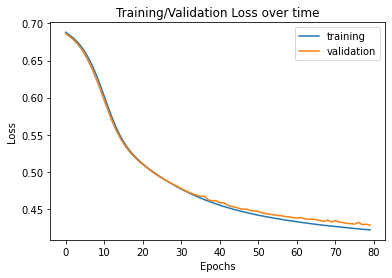

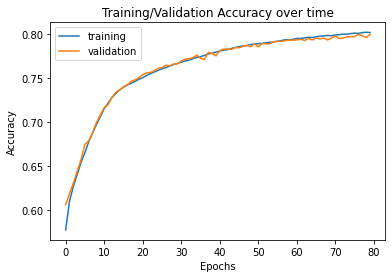

In [20]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs
print('Average accuracy of training data set: ' + str(np.mean(hist.history['accuracy'])))
print('Average accuracy of validation data set: ' + str(np.mean(hist.history['val_accuracy'])))
print()
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

### default NN for binary classification:

Average accuracy of training data set: 0.77, validation data set: 0.768

Final accuracy of training data set: 0.808, validation data set: 0.802

There isnt an issue with overfitting to data which is good! Total number of parameters is 12,857.




Took suprisingly number of epochs to converge, about 80. No real difference between training and validation

###NN Model, multiclass

In [21]:

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline



In [22]:
from sklearn.preprocessing import LabelBinarizer

label_transformer = LabelBinarizer()
train_labels_c = label_transformer.fit_transform(train_labels_c)
test_labels_c = label_transformer.fit_transform(test_labels_c)

ftest_labels_c = label_transformer.fit_transform(ftest_labels_c)

In [29]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD


epochs=80




num_features = train_xs_featurized.shape[1]

model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=6, activation='softmax', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = SGD(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', #use mean squared error
              metrics=['accuracy',
                       Recall(),
                       Precision()
                       ])  #AUC, accuracy, loss
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                12024     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 6)                 198       
Total params: 13,022
Trainable params: 13,022
Non-trainable params: 0
_________________________________________________________________


In [30]:
%%time
#train model
hist = model.fit(x=train_xs_featurized, 
         y = train_labels_c,
         batch_size=32,
         validation_data = (ftest_xs_featurized, ftest_labels_c),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

CPU times: user 16min 57s, sys: 3min 4s, total: 20min 2s
Wall time: 13min 4s


In [32]:
hist.history

{'accuracy': [0.49666303396224976,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4978463649749756,
  0.4981587529182434,
  0.5035830736160278,
  0.5122828483581543,
  0.524665117263794,
  0.5386945605278015,
  0.5517489314079285,
  0.5612533688545227,
  0.5688076615333557,
  0.5742888450622559,
  0.5785771608352661,
  0.5817106366157532,
  0.5838595032691956,
  0.5867089629173279,
  0.5885549187660217,
  0.5909310579299927,
  0.5931083559989929,
  0.5952098965644836,
  0.5972263216972351,
  0.5991101264953613,
  0.6001514792442322,
  0.6016755700111389,
  0.6032848954200745,
  0.6044492721557617,
  0.6066455245018005,
  0.6072514057159424,
  0.6089648604393005,
  0.6098735928535461,
  0.6114072203636169,
  0.6125905513763428,
  0.6137927770614624,
  0.6144080758094788,
  0.6156198382377625,
  0.6163771748542786

In [33]:
#print metrics for slides

print(hist.history['val_accuracy'][-1])

print(hist.history['val_recall_2'][-1])

print(hist.history['val_precision_2'][-1])

# calculate f1 score

f1 = 2*hist.history['val_precision_2'][-1]*hist.history['val_recall_2'][-1] / (hist.history['val_recall_2'][-1] + hist.history['val_precision_2'][-1])
print(f1)

0.6292449235916138
0.4795168936252594
0.7359558343887329
0.5806847778939365


Average accuracy of training data set: 0.5969124842435122
Average accuracy of validation data set: 0.5993515446782112

Final accuracy of training data set: 0.6333222985267639
Final accuracy of validation data set: 0.6327483654022217



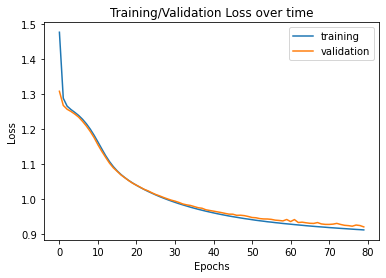

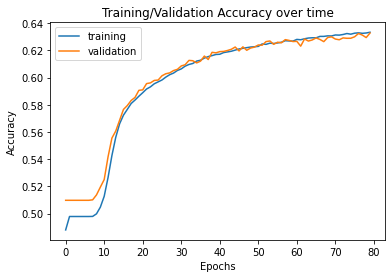

In [28]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs
print('Average accuracy of training data set: ' + str(np.mean(hist.history['accuracy'])))
print('Average accuracy of validation data set: ' + str(np.mean(hist.history['val_accuracy'])))
print()
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

Results, number of params = 13,022. Avg acc is 0.6 train, 0.598 validation. final accuracy is 0.634 train, 0.625 validation. 

###LSA regression

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

num_features = train_xs_featurized.shape[1]

#initialize BINARY classification model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=1, activation='linear', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
# opt = Adam(lr=0.001)
opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='mean_absolute_error', #use mean squared error
              metrics=['mse', 'mae' ]) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=train_xs_featurized, 
         y = train_labels_c,
         batch_size=32,
         validation_data = (test_xs_featurized, test_labels_c),
         epochs=40,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                12024     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 12,857
Trainable params: 12,857
Non-trainable params: 0
_________________________________________________________________


Final MSE of training data set: 0.8640269041061401
Final MSE of validation data set: 0.9226136207580566

Final MAE of training data set: 0.6233751773834229
Final MAE of validation data set: 0.6485312581062317



Text(0.5, 0, 'Epochs')

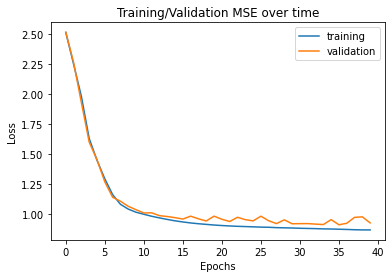

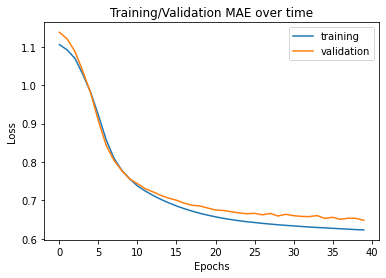

In [ ]:
epochs=40

#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mse'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mse'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mse'], label = 'training')
plt.plot(range(epochs), hist.history['val_mse'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot out mae
print('Final MAE of training data set: ' + str(np.mean(hist.history['mae'][-1])))
print('Final MAE of validation data set: ' + str(np.mean(hist.history['val_mae'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['mae'], label = 'training')
plt.plot(range(epochs), hist.history['val_mae'], label = 'validation')
plt.title('Training/Validation MAE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')



In [ ]:
#get predictions
test_predictions = model.predict(test_xs_featurized).flatten()
# round_preds = np.round(test_predictions)

# import math
# num_correct_preds   = sum([1 if test_labels_c[i] == math.floor(test_predictions[i]) else 0 for i in range(len(round_preds))])



#calculate number of correct predictions
num_correct_preds   = sum([1 if test_labels_c[i] == round_preds[i] else 0 for i in range(len(round_preds))])
print(num_correct_preds)

print(num_correct_preds/len(round_preds))



12557
0.48192354927847714


In [ ]:
len(round_preds)

26056

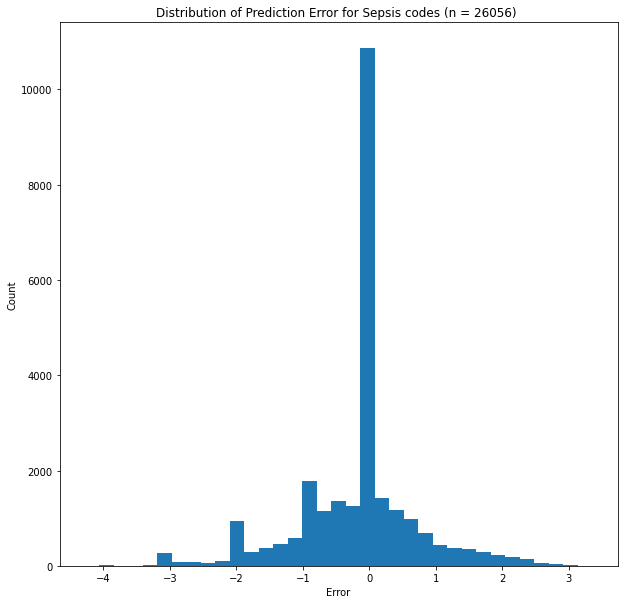

In [ ]:

from matplotlib.pyplot import figure
figure(figsize=(10, 10))

#compare predictions to actual labels

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels_c, test_predictions)
# plt.xlabel('True Values [MPG]')
# plt.ylabel('Predictions [MPG]')
# lims = [0, 5]
# plt.xlim(lims)
# plt.ylim(lims)
# plt.plot(lims, lims)


error = test_predictions - test_labels_c
plt.hist(error, bins=35)
plt.xlabel('Error')
_ = plt.ylabel('Count')
plt.title('Distribution of Prediction Error for Sepsis codes (n = 26056) ')
plt.show()

###LSA  similar word embeddings

In [ ]:
def show_similar_words(tokenizer, reps, tokens):
    # reps = reps.detach().numpy()
    reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for token in tokens:
        word = vectorizer.get_feature_names()[token]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:10]:
            print(" ", vectorizer.get_feature_names()[j], "%.3f" % sims[j])



In [ ]:
reps = reps_tfidf
words = ["sepsis","septicemia", "antibiotic", "shock","infection", "septic", "blood", 
         "chest" ,"radiology", "condition", "brain" ]
show_tokens = [vectorizer.get_feature_names().index(word) for word in words]
show_similar_words(tokenizer, reps, show_tokens)


sepsis 8067
  dic 0.973
  pneumococcal 1.022
  mellituscoagulopathy 1.036
  noninsulin 1.036
  hepatico 1.122
  tapped 1.173
  hepatoma 1.202
  sepsishypotension 1.217
  sepsisacute 1.218
septicemia 8100
  accidentally 1.091
  tuesday 1.336
  yearold 1.374
  extract 1.392
  think 1.393
  cbd 1.418
  extraction 1.423
  age 1.428
  perc 1.429
antibiotic 451
  longterm 0.305
  sch 0.369
  abx 0.380
  placment 0.396
  centmidnot 0.599
  antibx 0.664
  vancomycin 0.674
  parenteral 0.676
  supervising 0.697
shock 8161
  cardiogenic 0.290
  septic 0.675
  hypovolemic 0.770
  mellitusseptic 0.795
  deficency 0.805
  cholangitisseptic 0.812
  cs 0.846
  hypotensionrenal 0.853
  bradycardiahypotensionsepsis 0.891
infection 4512
  nidus 0.610
  occult 0.989
  fungal 1.022
  pneumoniaurinary 1.022
  mucor 1.076
  infe 1.096
  superimposed 1.118
  failureurinary 1.125
  db 1.127
septic 8099
  shock 0.675
  emboli 0.691
  physiology 0.710
  embolus 0.728
  bradycardiahypotensionsepsis 1.037
  sepsi

###Results (default sklearn kits)

## default Logistic regression (NOT SGD classifier), dim=500, binary classification: 

Accuracy = 0.8042066896996849 

Precision = 0.8246696732336419 

Recall = 0.7799311583358276 

F1 = 0.8016767296081221 

AUC = 0.8045705888018251

## default Logistic regression (NOT SGD classifier) for multi-class classification:

Accuracy = 0.638520824632674 

Precision = 0.5999569407363056 

Recall = 0.638520824632674 

F1 = 0.5854310062982707 



## default NN for multi-class classification:

# (NOT DONE) Run LDA Topic Modeling

In [ ]:
from gensim import corpora
from gensim.models import LsiModel

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

number_of_topics=6
words=10
document_list,titles=load_data("","corpus.txt")
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

NameError: ignored

# Word2Vec model

In [ ]:
# device = 'cuda'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Word2VecModel(nn.ModuleList):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.

    def __init__(self, vocab_size, embed_dim):
      super(Word2VecModel, self).__init__()

        #word2vec: 2 linear layers, 1 softmax
      
      self.lin1 = nn.Linear(embed_dim, vocab_size+1) #layer calculates embedded representations
        
      self.softmax = nn.Softmax().to(device)
      self.embed =  nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)  #get embedded representations from embedding dict


    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return a set of scores for predicting the word 
        # in the middle of the context

        context = context.to(device)

        # Your code here!  torch.LongTensor(context)
        out_embed = self.embed(context).to(device=device)  #convert indices to sparse layer lookup table
        avg_embed = torch.mean(out_embed, dim = 1).to(device=device)
        out_linear = self.lin1(avg_embed).to(device=device)
        out = self.softmax(out_linear).to(device=device)

        return out

    def getEmbedWeights(self): #get matrix of embedded word representations
      
      return self.embed.weight.to(device=device) 


In [ ]:
# #format tokens into ngrams

# n = 2
# def ngrams(input):
#     output=[]
#     for i in range(len(input)-n+1):
#         output.append(input[i:i+n])
#     return output

# # ngrams(['a', 'b', 'c', 'd']) # [['a', 'b'], ['b', 'c'], ['c', 'd']]

In [ ]:
def get_ngrams(tokenized_corpus, window_size):
    # review = train_labels_b
    ngrams = []
    for i, review in enumerate(tokenized_corpus):
        # print(review)
        for j, word in enumerate(review):
            min_ind = max(0, j-window_size)
            max_ind = min(len(review), j+window_size+1)
            ctx = np.zeros(2 * window_size, dtype=np.int64) - 1
            for ik, k in enumerate(range(min_ind, j)):
                ctx[ik] = review[k]
            for ik, k in enumerate(range(j+1, max_ind)):
                ctx[window_size+ik] = review[k]
            ngrams.append((ctx, review[j]))
    return ngrams

In [ ]:
rebuilt_train_notes_cleaned[0]

'pm chest portable ap clip clip number radiology reason acute sob hospital medical condition year old man pvdischemic llecad heparinwithacute sob low bps reason examination acute sob final report indication shortness breath low blood pressure comparison make previous study earlier day leave picc line remain place terminate distal superior vena cava patient sp mediansternotomy coronary bypass surgery heart enlarge stable size previously note mild congestive heart failure pattern demonstrate significantly change allow difference technique confluent area consolidation see either lung pleural effusion evident although left cp sulcus exclude impression significant change since recent study earlier day persistent mild congestive heart failure pattern'

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer

# t = Tokenizer(num_words=10000,oov_token=0)

# t.fit_on_texts(rebuilt_train_notes_cleaned)
# encoded_notes = t.texts_to_matrix(rebuilt_train_notes_cleaned, mode='count')
# #token 
# encoded_notes[0]

array([0., 0., 2., ..., 0., 0., 0.])

In [34]:
#get padded notes
pad_notes = pd.read_csv('gdrive/MyDrive/BMI707_Final_Project/TRAINING_notes_padded.csv')

In [ ]:
pad_notes_only.head()

,token1,token2,token3,token4,token5,token6,token7,token8,token9,token10,token11,token12,token13,token14,token15,token16,token17,token18,token19,token20,token21,token22,token23,token24,token25,token26,token27,token28,token29,token30,token31,token32,token33,token34,token35,token36,token37,token38,token39,token40,...,token473,token474,token475,token476,token477,token478,token479,token480,token481,token482,token483,token484,token485,token486,token487,token488,token489,token490,token491,token492,token493,token494,token495,token496,token497,token498,token499,token500,token501,token502,token503,token504,token505,token506,token507,token508,token509,token510,token511,token512
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,62,114,366,80,86,375,103,482,32,526,755,97,1023,122,119,36,769,27,28,21,808,474,139,1175,929,256,23,161,32,157,224,45,250,166,179,114,366,80,86,375
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,321,129,12,40,126,206,225,112,38,98,106,506,488,434,145,68,101,40,60,19,83,93,78,14,206,225,112,38,98,106,145,68,434,239,150,106,23,44,883,272
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,429,144,252,1291,30,341,363,4365,6,636,31,1549,882,4646,1665,1437,23,30,1490,548,108,41,521,4,151,201,31,753,43,214,349,362,183,1075,2387,315,708,139,269,31
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,27,194,42,526,42,27,194,182,97,1202,127,75,279,295,152,635,2833,6,486,133,69,773,1,897,27,524,199,112,28,21,23,12,31,454,6,42,57,69,5820,256
4,601,173,253,926,455,2606,433,1112,234,2026,173,183,2276,363,4,241,589,586,242,268,1309,1426,107,1099,269,72,286,4,83,103,269,72,1672,67,154,269,92,112,1478,3810,...,587,138,4179,1478,4,269,1566,2962,2785,2425,81,671,6,241,1,392,349,362,325,308,252,724,1632,1478,325,2277,396,252,30,433,1679,2658,41,6,269,753,6,136,269,708


In [35]:
pad_notes_only = pad_notes.drop(['Unnamed: 0', 'binary_outcome', 'outcome_count', 'ID'], axis=1)

#convert to list
pad_notes_only = pad_notes_only.values.tolist()

In [36]:
#get all start positions of sequences
start_positions = [(next((i for i, x in enumerate(note) if x), None)) for note in pad_notes_only]

print(len(start_positions))

# trim 0s off all sequences 

unpad_notes_only = [pad_notes_only[i][start_positions[i]:] for i in range(len(start_positions))]

105635


In [ ]:

def learn_reps_word2vec(tokenized_input, window_size, rep_size, n_epochs, n_batch):
    #This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    #apply 6.864 ngrams
    ngrams_input = get_ngrams(tokenized_input, 2)

    #apply my ngrams
    # ngrams_input = [ngrams(post) for post in tokenized_input ]

    # device = torch.device('cuda')  # run on colab gpu
    # device = 'cuda'
    
    model = Word2VecModel(10000, rep_size).to(device=device)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    # next(model.parameters()).device

    loader = torch_data.DataLoader(ngrams_input, batch_size=n_batch, shuffle=True)

    # print(ngrams_input.shape)
    # print(ngrams_input)

    # Use cross-entropy loss function for Word2Vec!
    loss_fn = torch.nn.CrossEntropyLoss() #combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

    losses = []  # Potentially useful for debugging (loss should go down!)
    
    from tqdm import tqdm

    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.


            # Here, perform a forward pass to compute predictions for the model.
            
            context = context + 1
          
            preds = model.forward(context).to(device)  # Your code here!

            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradients
            # of the model parameters, perform the backward pass, and
            # update the model parameters.

            #compute loss
            loss = loss_fn(preds, label.to(device))  # Your code here!
            #zero gradients
            opt.zero_grad()
            #perform backward pass
            loss.backward()  
            #update parameters
            opt.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.getEmbedWeights()  # Your code here!

    return embedding_matrix
    

In [ ]:
# Use the function you just wrote to learn Word2Vec embeddings on a word-level:
reps_word2vec = learn_reps_word2vec(unpad_notes_only[1:50000],  #reduce size to stop RAM from crashing
                                    2,   #window size
                                    100, #embedding size, was initially 500 but thing timed out 
                                    10, 
                                    5)

100%|██████████| 10/10 [4:38:04<00:00, 1668.42s/it]


In [37]:
# torch.save(reps_word2vec, 'gdrive/MyDrive/BMI707_Final_Project/W2V_embed_weights_100dim_2window.pt') 

#load later on
saved_weights = torch.load('gdrive/MyDrive/BMI707_Final_Project/W2V_embed_weights_100dim_2window.pt', map_location=torch.device('cpu'))

In [ ]:
saved_weights.shape

torch.Size([10001, 100])

In [ ]:
#also need a vectorizer for W2V!

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(rebuilt_train_notes_cleaned)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
reps_word2vec = saved_weights[1:]
reps_word2vec.shape
reps_word2vec[1]

print(reps_word2vec.shape[0])
print()
np.array(test_xs[5])
x = test_xs[5].toarray().T * reps_word2vec.detach().numpy()
s = np.sum(x, axis=0)

print(x.shape)
print(s.shape)
s

10000

(10000, 100)
(100,)


array([-56.73957511, -23.55649169,  16.21447103,  45.92368647,
       -14.81462181, -13.04583421, -16.85731123, -12.07596856,
        20.149739  , -17.13384655, -34.98798745, -22.2729107 ,
         6.98989226, -48.97382268,  -1.02768507,  56.15998655,
         9.8504728 ,  25.34208852,  -0.26562132,  -6.293958  ,
       -30.69015879,  -9.64496394,  10.11804399,  30.51173593,
       -25.79955222,  -1.52103417,  25.44668548,  16.25909559,
       -24.04422168, -43.80462608,  -4.47637962,  -3.74787884,
       -15.83384761,  23.63422448,  23.96501902, -28.82987423,
       -12.86437154,  -2.91303063,  -8.52720036,  13.93921805,
         8.12654941,  17.26940014,   4.18859453,  73.81219077,
       -26.90271185,  -8.31385394,  26.79399369,  -6.60617627,
        -3.11568314,  -6.0819053 , -11.76172734, -34.47939221,
       -27.45067148, -25.22392347,   3.95674599, -19.44629682,
         2.2839511 , -26.9508808 ,  -1.92165914,  40.62509754,
        27.58869465, -30.48810527,   9.80203434,  -1.41

In [ ]:
test_xs[5].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [38]:
def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = np.zeros((xs.shape[0], reps_word2vec.shape[1]))  

    for j in range(xs.shape[0]):
      # print(xs[j].shape)
      # print(reps_word2vec[:10000,].shape)

      x = xs[j].toarray().T * reps_word2vec.detach().numpy()
      s = np.sum(x, axis=0)
      # print(newrow)


      # newrow = xs[j,0] * reps_word2vec[0] #shape is (1, 500)
      # for i in range(1, xs.shape[1]):
      #   newrow += xs[j,i] * reps_word2vec[i]       

      feats[j] = (s / xs.shape[1])

    #average all the word embeddings in review to create overall embedding

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))


reps_word2vec = saved_weights[1:]

# train_xs = vectorizer.transform(rebuilt_train_notes_cleaned) #convert to term-document matrix
# test_xs = vectorizer.transform(rebuilt_test_notes_cleaned)

train_xs_w2v = w2v_featurizer(train_xs)
test_xs_w2v = w2v_featurizer(test_xs)

ftest_xs_w2v = w2v_featurizer(ftest_xs)

print(f"Word2Vec features, {len(outcome_train)} examples")


Word2Vec features, 105635 examples


##Word2Vec regression model

In [ ]:
np.unique(train_labels_c)


array([0, 1, 2, 3, 4, 5])

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

num_features = train_xs_w2v.shape[1]
epochs = 70

#initialize BINARY classification model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=1, activation='linear', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=0.001)
# opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='mean_absolute_error', #use mean squared error
              metrics=['mse', 'mae' ]) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

#train model
hist = model.fit(x=train_xs_w2v, 
         y = train_labels_c,
         batch_size=32,
         validation_data = (ftest_xs_w2v, ftest_labels_c),
         epochs=70,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Final MSE of training data set: 0.99310302734375
Final MSE of validation data set: 1.1045770645141602

Final MAE of training data set: 0.6667900681495667
Final MAE of validation data set: 0.7213680744171143



Text(0.5, 0, 'Epochs')

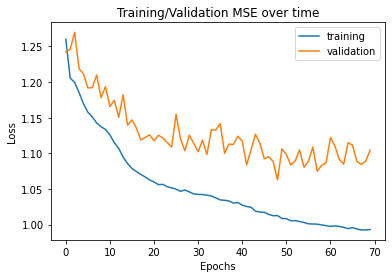

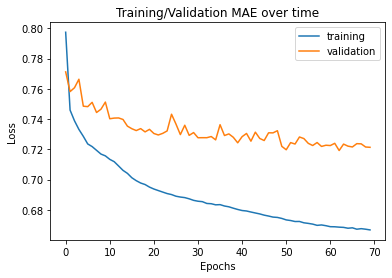

In [ ]:
epochs=70

#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mse'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mse'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mse'], label = 'training')
plt.plot(range(epochs), hist.history['val_mse'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot out mae
print('Final MAE of training data set: ' + str(np.mean(hist.history['mae'][-1])))
print('Final MAE of validation data set: ' + str(np.mean(hist.history['val_mae'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['mae'], label = 'training')
plt.plot(range(epochs), hist.history['val_mae'], label = 'validation')
plt.title('Training/Validation MAE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')



In [ ]:
#get predictions
test_predictions = model.predict(test_xs_w2v).flatten()
round_preds = np.round(test_predictions)

#calculate number of correct predictions
num_correct_preds   = sum([1 if test_labels_c[i] == round_preds[i] else 0 for i in range(len(round_preds))])
print(num_correct_preds)

print(num_correct_preds/len(round_preds))



13257
0.5087887626650291


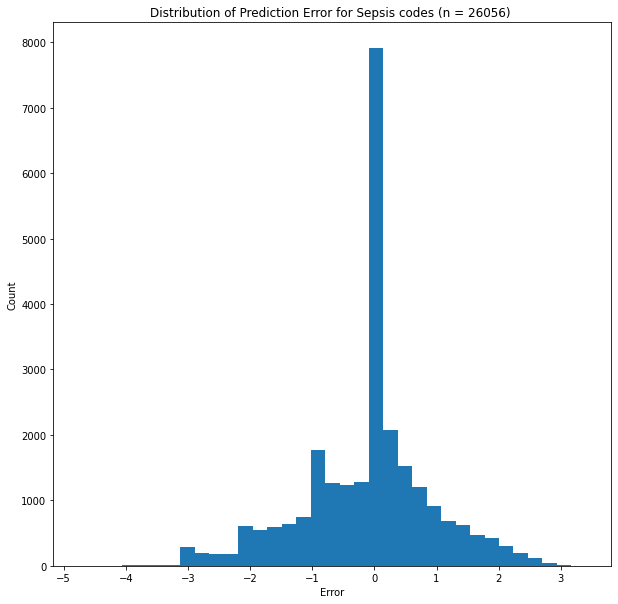

In [ ]:

from matplotlib.pyplot import figure
figure(figsize=(10, 10))

#compare predictions to actual labels

test_predictions = model.predict(test_xs_w2v).flatten()
round_preds = np.round(test_predictions)

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels_c, test_predictions)
# plt.xlabel('True Values [MPG]')
# plt.ylabel('Predictions [MPG]')
# lims = [0, 5]
# plt.xlim(lims)
# plt.ylim(lims)
# plt.plot(lims, lims)


error = test_predictions - test_labels_c
plt.hist(error, bins=35)
plt.xlabel('Error')
_ = plt.ylabel('Count')
plt.title('Distribution of Prediction Error for Sepsis codes (n = 26056) ')
plt.show()

##Implement binary downstream classifier

In [52]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam


num_features = train_xs_w2v.shape[1]

epochs=30

#initialize BINARY classification model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=1, activation='sigmoid', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=0.001)
# opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='binary_crossentropy', #use mean squared error
              metrics=['accuracy', 'AUC',
                       Recall(),
                       Precision()
                       ])  #AUC, accuracy, loss
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time

#train model
hist = model.fit(x=train_xs_w2v, 
         y = train_labels_b,
         batch_size=32,
         validation_data = (ftest_xs_w2v, ftest_labels_b),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

CPU times: user 8min 25s, sys: 1min 13s, total: 9min 39s
Wall time: 6min 3s


In [41]:
#print metrics for slides

print(hist.history['val_accuracy'][-1])

print(hist.history['val_auc'][-1])

print(hist.history['val_recall_3'][-1])

print(hist.history['val_precision_3'][-1])

# calculate f1 score

f1 = 2*hist.history['val_precision_3'][-1]*hist.history['val_recall_3'][-1] / (hist.history['val_recall_3'][-1] + hist.history['val_precision_3'][-1])
print(f1)

0.7520206570625305
0.8333671689033508
0.7422893643379211
0.7494778037071228
0.7458662644093572


Average accuracy of training data set: 0.7609182556470235
Average accuracy of validation data set: 0.7529052734375

Final loss of training data set: 0.4648154377937317
Final loss of validation data set: 0.4903706908226013

Average AUC of training data set: 0.8441284636656443
Average AUC of validation data set: 0.8371143162250518



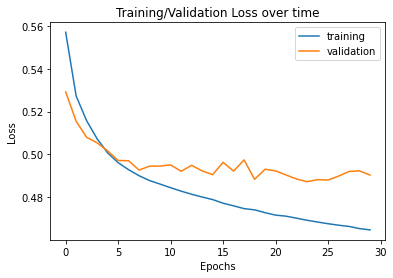

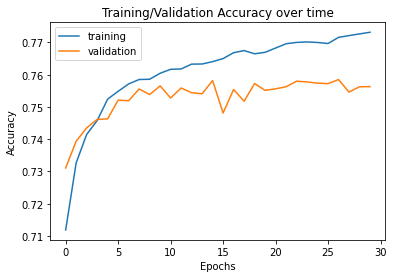

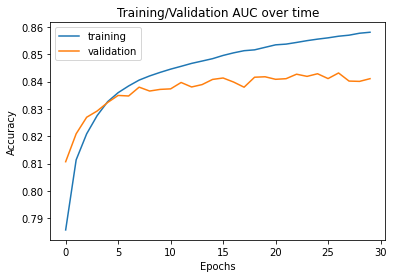

In [ ]:
### For Adam optimizer

import matplotlib.pyplot as plt
# epochs=30

# Plot the training and validation loss vs. epochs
print('Average accuracy of training data set: ' + str(np.mean(hist.history['accuracy'])))
print('Average accuracy of validation data set: ' + str(np.mean(hist.history['val_accuracy'])))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()

print('Average AUC of training data set: ' + str(np.mean(hist.history['auc'])))
print('Average AUC of validation data set: ' + str(np.mean(hist.history['val_auc'])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

Average accuracy of training data set: 0.6756395149230957
Average accuracy of validation data set: 0.684441202878952

Final loss of training data set: 0.5544751286506653
Final loss of validation data set: 0.5491310358047485

Average AUC of training data set: 0.7379204559326172
Average AUC of validation data set: 0.7496726548671723



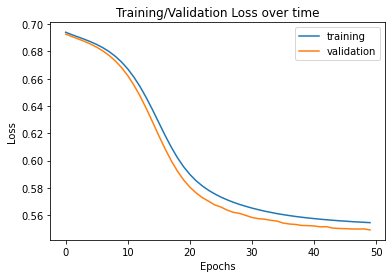

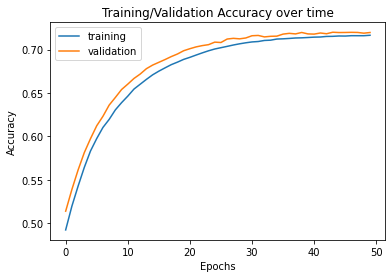

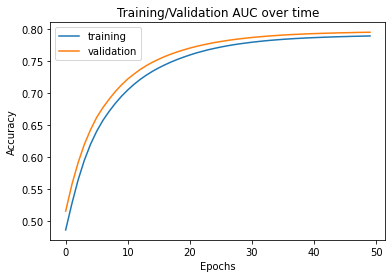

In [ ]:
### For SGD optimizers

import matplotlib.pyplot as plt


epochs=50

# Plot the training and validation loss vs. epochs
print('Average accuracy of training data set: ' + str(np.mean(hist.history['accuracy'])))
print('Average accuracy of validation data set: ' + str(np.mean(hist.history['val_accuracy'])))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()

print('Average AUC of training data set: ' + str(np.mean(hist.history['auc'])))
print('Average AUC of validation data set: ' + str(np.mean(hist.history['val_auc'])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

##Multiclass classifier

In [ ]:
#multiclass classifier

In [58]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

# from sklearn.preprocessing import LabelBinarizer
# label_transformer = LabelBinarizer()
# train_labels_c = label_transformer.fit_transform(train_labels_c)
# test_labels_c = label_transformer.fit_transform(test_labels_c)

epochs = 30

num_features = train_xs_w2v.shape[1]

model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (softmax function)
model.add(Dense(units=6, activation='softmax', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', #use mean squared error
              metrics=['accuracy', 
                       Recall(),
                       Precision()
                       ])  #AUC, accuracy, loss
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch






Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 6)                 198       
Total params: 3,422
Trainable params: 3,422
Non-trainable params: 0
_________________________________________________________________


In [59]:
%%time

#train model
hist = model.fit(x=train_xs_w2v, 
         y = train_labels_c,
         batch_size=32,
         validation_data = (ftest_xs_w2v, ftest_labels_c),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

CPU times: user 6min 21s, sys: 1min 8s, total: 7min 30s
Wall time: 4min 55s


In [60]:
hist.history

{'accuracy': [0.5517394542694092,
  0.5723481774330139,
  0.5798267722129822,
  0.5857055187225342,
  0.5871538519859314,
  0.590675413608551,
  0.5936574339866638,
  0.5952193737030029,
  0.597623884677887,
  0.5983812212944031,
  0.5992805361747742,
  0.6002934575080872,
  0.6015714406967163,
  0.6022246479988098,
  0.6041085124015808,
  0.604752242565155,
  0.6054053902626038,
  0.6041747331619263,
  0.6062195301055908,
  0.606863260269165,
  0.6073839068412781,
  0.6074596643447876,
  0.6071377992630005,
  0.6081696152687073,
  0.6083873510360718,
  0.6079803109169006,
  0.6081128120422363,
  0.6093529462814331,
  0.6086997389793396,
  0.6102617383003235],
 'loss': [1.1058541536331177,
  1.051192283630371,
  1.030015230178833,
  1.017513632774353,
  1.0095884799957275,
  1.0020815134048462,
  0.9950606822967529,
  0.9909768104553223,
  0.9871508479118347,
  0.9838473200798035,
  0.9810788035392761,
  0.9788198471069336,
  0.9763057827949524,
  0.9744516015052795,
  0.97195607423782

In [61]:
#print metrics for slides

print(hist.history['val_accuracy'][-1])

# print(hist.history['val_auc'][-1])

print(hist.history['val_recall_8'][-1])

print(hist.history['val_precision_8'][-1])

# calculate f1 score

f1 = 2*hist.history['val_precision_8'][-1]*hist.history['val_recall_8'][-1] / (hist.history['val_recall_8'][-1] + hist.history['val_precision_8'][-1])
print(f1)

0.5955007672309875
0.4479855000972748
0.7070721983909607
0.5484714621886575


#Check how many training instances say sepsis

In [ ]:
print(len(rebuilt_train_notes_cleaned))
count_occur = [0 if re.search('sepsis|septic|septicemia|septicaemia', note)==None else 1 for note in rebuilt_train_notes_cleaned]
sum(count_occur)

105635


11481

In [ ]:
import re
x = re.search("black",rebuilt_test_notes_cleaned[0])
x == None

True

In [ ]:
11481/105635

0.10868556823022672

sepsis|septic|septicemia|septicaemia: 11481/105635 (10.9%) training instances have the word sepsis in them. And 2962 / 26056 (11.4%) for the test set. 

SEPSIS: 9882/105635 (90.6%) training instances have the word sepsis in them. And 2617 / 26056 (10%) for the test set. 

##W2V similar word embeddings

In [ ]:
def show_similar_words(tokenizer, reps, tokens):
    reps = reps.detach().numpy()
    reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for token in tokens:
        word = vectorizer.get_feature_names()[token]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:10]:
            print(" ", vectorizer.get_feature_names()[j], "%.3f" % sims[j])



In [ ]:
reps = reps_word2vec
tokenizer = vectorizer.build_tokenizer()
words = ["sepsis","septicemia", "antibiotic", "shock","infection", "septic", "blood", 
         "chest" ,"radiology", "condition", "brain" ]
show_tokens = [vectorizer.get_feature_names().index(word) for word in words]
show_similar_words(tokenizer, reps, show_tokens)

# From NLP 6.864
# reps = learn_reps_lsa(td_matrix, 500)
# words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
# show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
# lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

sepsis 8067
  anterosuperior 1.098
  pnumonia 1.150
  abundant 1.232
  abnormalaties 1.262
  gre 1.262
  serial 1.302
  hydronephrosis 1.303
  deviation 1.308
  arteriography 1.313
septicemia 8100
  comply 0.460
  cost 0.772
  cea 1.148
  carcinomatosis 1.299
  motion 1.307
  infarctiontelemetry 1.308
  obtai 1.309
  absorption 1.327
  code 1.328
antibiotic 451
  cooperate 0.730
  certainly 0.749
  contrastclip 0.870
  bleedstroke 0.871
  comparsion 0.922
  extensor 0.932
  embolectomy 0.965
  diff 1.041
  avr 1.101
shock 8161
  moderatetolarge 1.255
  mvr 1.298
  unaltered 1.326
  home 1.330
  painchest 1.368
  subtraction 1.383
  maroon 1.389
  orally 1.408
  pseudo 1.438
infection 4512
  pancytopeniafebrile 1.298
  uauvc 1.305
  wax 1.324
  cholecystis 1.338
  medication 1.364
  mixed 1.371
  tiny 1.372
  de 1.379
  asmr 1.387
septic 8099
  timed 1.310
  gauze 1.320
  csection 1.366
  plethoric 1.373
  insula 1.376
  chestmediastinum 1.383
  administrate 1.396
  pulmonar 1.397
  lef

In [ ]:
type(vectorizer.get_feature_names())

list

In [ ]:
vectorizer.get_feature_names().index("sepsis")

8067